# ME 592 Final Project
## Jake Bergfeld, Mohammad Rashid Mohammad Shoaib
#### Engineering Image Analysis - Automated Chest X-ray classifier

##### Gathering data from Kaggle - Link to data: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
# !pip install kaggle
# !mkdir .kaggle  #naming required by kaggle API, creates a hidden folder
# !cp /home/exouser/Downloads/kaggle.json /home/exouser/.kaggle/kaggle.json

##### <u>Confirming location of Kaggle API token was moved successfully

In [2]:
# !cd .kaggle && ls

##### <u>Downloading the specific dataset and confirming locations

In [185]:
# !kaggle datasets list -s 'Chest X-ray images'

In [4]:
# !kaggle datasets download -d 'paultimothymooney/chest-xray-pneumonia'

In [5]:
# !sudo apt-get install unzip
# !unzip chest-xray-pneumonia.zip /home/exouser/ME592/Final Project

### <u>Data Information: 

### Input image size varies
    
##### The 2 classes to predict are:
 - Normal/Healthy lungs
 - Pneumonia

##### *Formula to calculate the number of parameters in a CNN:*
   -  Convolutional layer: (in_channels x out_channels x kernel_height x kernel_width) + out_channels
   -  Batch normalization layer: 2 x num_features
   -  ReLU activation layer: 0 (no parameters)
   -  Max pooling layer: 0 (no parameters)
   -  Fully connected layer: (in_features x out_features) + out_features

### <u>Library Imports & Transforming Data

In [19]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import shutil
import random

In [20]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()

cuda


In [21]:
#Transform the input images
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

### <u>Dataloader and Pre-training

In [22]:
#Create a dataloader

#Directory path for the training & test images
train_path='/home/exouser/ME592/Final Project/chest-xray-pneumonia/train'
test_path='/home/exouser/ME592/Final Project/chest-xray-pneumonia/test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=16, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=16, shuffle=True
) 


In [23]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)


['NORMAL', 'PNEUMONIA']


### <u>Step 1: Build and train a CNN model

In [26]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.relu3 = nn.ReLU()

        self.fc1 = nn.Linear(in_features=128 * 18 * 18, out_features=1024)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.pool(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.pool(output)

        output = output.view(-1, 128 * 18 * 18)
        output = self.fc1(output)
        output = self.relu4(output)
        output = self.fc2(output)
        
        #Final layer can be a sigmoid activation layer since only using 2 classes. This will help push the network, on/off functionality. Should help with test acc

        return output
        

In [27]:
model=ConvNet(num_classes=2).to(device)

In [28]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.003,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
# loss_function=nn.BCELoss()
#Since binary problem, can use Binary cross entropy function instead to perform the sigmoid entropy automatically (numerical stability)

In [29]:
num_epochs=20

In [30]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpeg'))
test_count=len(glob.glob(test_path+'/**/*.jpeg'))

In [31]:
print(train_count)
print(test_count)

5216
624


In [32]:
train_acc_list = []
test_acc_list = []
loss_list = []

In [33]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    # print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy))

    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)
    loss_list.append(train_loss)
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    
       

Epoch: 0 Train Loss: tensor(2.0885) Train Accuracy: 0.9235046012269938 Test Accuracy: 0.7339743589743589
Epoch: 1 Train Loss: tensor(0.1120) Train Accuracy: 0.9564800613496932 Test Accuracy: 0.8060897435897436
Epoch: 2 Train Loss: tensor(0.1007) Train Accuracy: 0.9622315950920245 Test Accuracy: 0.7403846153846154
Epoch: 3 Train Loss: tensor(0.0927) Train Accuracy: 0.9664493865030674 Test Accuracy: 0.7163461538461539
Epoch: 4 Train Loss: tensor(0.0913) Train Accuracy: 0.9677914110429447 Test Accuracy: 0.7419871794871795
Epoch: 5 Train Loss: tensor(0.0802) Train Accuracy: 0.968558282208589 Test Accuracy: 0.7948717948717948
Epoch: 6 Train Loss: tensor(0.0828) Train Accuracy: 0.9727760736196319 Test Accuracy: 0.7227564102564102
Epoch: 7 Train Loss: tensor(0.0914) Train Accuracy: 0.9700920245398773 Test Accuracy: 0.8685897435897436
Epoch: 8 Train Loss: tensor(0.0892) Train Accuracy: 0.9712423312883436 Test Accuracy: 0.7435897435897436
Epoch: 9 Train Loss: tensor(0.1060) Train Accuracy: 0.96

In [34]:
# train_acc_list.append(train_accuracy)
# test_acc_list.append(test_accuracy)
# loss_list.append(train_loss)

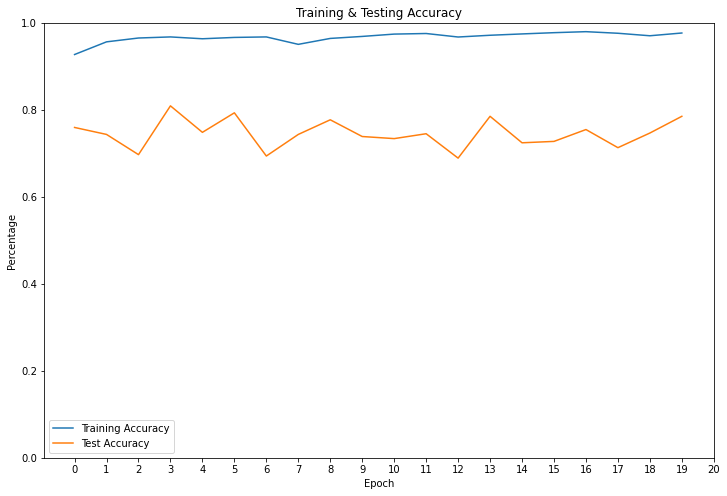

In [17]:
# Plot the results
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,8))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xticks(range(21))
plt.ylim(0,1)
plt.show()

### <u>Now using unlabeled images to evaluate the network:

In [173]:
#Loading more libraries
import torch
import torch.nn as nn
import numpy as np
import torch.functional as F
import os
import pathlib
import glob
import cv2
from torch.autograd import Variable
from torchvision.transforms import transforms
from torchvision.models import squeezenet1_1
from io import open
from PIL import Image
import matplotlib.pyplot as plt

In [174]:
pred_path='/home/exouser/ME592/Final Project/chest-xray-pneumonia/val'

In [175]:
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(num_classes=2)
model.load_state_dict(checkpoint)
model.eval()

ConvNet500k(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=41472, out_features=1024, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [176]:
#Transform the prediction input images
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [177]:
#Prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    image_tensor=transformer(image).float()
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor=image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    output=model(input)
    index=output.data.numpy().argmax()
    pred=classes[index]
    
    return pred

In [178]:
images_path=glob.glob(pred_path+'/*.jpg')

In [182]:
pred_dict={}

for i in images_path:
    file_name = os.path.basename(i) 
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)

In [184]:
pred_dict

{}